## 1. Подключение библиотек и функций

3. Корреляция + графики для данных

In [8]:
import numpy as np
import pandas as pd

#Модуль для разбиения данных
from sklearn.model_selection import train_test_split

#Метрика для оценки качества предсказания модели
from sklearn.metrics import r2_score as r2

#Модуль для стандартизации данных
from sklearn.preprocessing import StandardScaler

#Импорт моделей
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor

# Модули для визуализации данных
import matplotlib.pyplot as plt
import seaborn as sb

%matplotlib inline

## 2. Пути к файлам и директориям

In [2]:
TRAIN_DATASET_PATH = '../data/Real Estate Price Prediction/train.csv'
TEST_DATASET_PATH = '../data/Real Estate Price Prediction/test.csv'
PREDICTION_PATH = '../data/Real Estate Price Prediction/prediction.csv'

## 3. Создание класса для обработки и подготовки данных

In [230]:
class DataPipeLine:
    """Подготовка исходных данных"""
    
    def __init__(self):
        self.medians = None
        self.rooms_median = None
        self.house_year_median = None
        self.kitchen_square_median = None
        self.life_square_median = None
        self.median_square_meter_price_by_district = None

        
    def get_stat(self, df):
        """
        Извлечение статистических параметров тренировочного набора данных
        для их использования при подготовке тренировочного, валидационного и тестового наборов данных
        """
        
        # Получаем медианы для признаков, в наблюдениях которых имеются пропуски для их заполнения
        self.medians = df[['LifeSquare', 'Healthcare_1']].median()
        self.rooms_median = df['Rooms'].median()
        self.house_year_median = df['HouseYear'].median()
        self.kitchen_square_median = df['KitchenSquare'].median()
        self.life_square_median = df['LifeSquare'].median()
    
    
    def correcting_data(self, df):
        """
        Корректировка данных на предмет исключения выбросов, неправдоподобных значений,
        заполнения пустых значений, а также добавления (исключения) параметров
        """
        
        # Приведение типов данных
        df['Id'] = df['Id'].astype(str)
        df['DistrictId'] = df['DistrictId'].astype(str)
        
        # Заполнение пропусков
        df[['LifeSquare', 'Healthcare_1']] = df[['LifeSquare', 'Healthcare_1']].fillna(self.medians)
        
        # Корректировка выбросов и неправдоподобных значений
        
        ## корректировка выбросов в данных о количестве комнат
        df.loc[df['Rooms'].isin([0, 10, 19]), 'Rooms'] = self.rooms_median
        ## корректировка выбросов в данных об этажности домов
        df.loc[df['HouseFloor'] == 0, 'HouseFloor'] = df.loc[df['HouseFloor'] == 0, 'Floor']
        ## корректировка значений годов, превышающих текущий
        df.loc[df['HouseYear'] > 2022, 'HouseYear'] = self.house_year_median 
        
        ## корректировка площади кухни, выпадающей за диапазон [6, 40], при этом нулевые площади допускаются,
        ## так как кухня может быть объединина с жилой (например квартиры-студии)
        df.loc[(df['KitchenSquare'] < 6) & (df['KitchenSquare'] != 0), 'KitchenSquare'] = 6.0
        df.loc[df['KitchenSquare'] > 40, 'KitchenSquare'] = self.kitchen_square_median
        
        ## коррекрировка жилой площади, меньшей 10
        df.loc[df['LifeSquare'] < 10, 'LifeSquare'] = 10.0
        df.loc[df['LifeSquare'] > df['LifeSquare'].quantile(.99), 'LifeSquare'] = self.life_square_median
        
        ## корректировка общей площади, когда она меньше чем сумма площади кухни и жилых помещений
        df.loc[df['Square'] < df['LifeSquare'] + df['KitchenSquare'], 'Square'] =\
            (df.loc[df['Square'] < df['LifeSquare'] + df['KitchenSquare'], 'LifeSquare'] +\
                df.loc[df['Square'] < df['LifeSquare'] + df['KitchenSquare'], 'KitchenSquare'])
        
        # Преобразование категориальных признаков в числовые
        df['Ecology_2_bin'] = df['Ecology_2'].replace({'A':0, 'B': 1})
        df['Ecology_3_bin'] = df['Ecology_2'].replace({'A':0, 'B': 1})
        df['Shops_2_bin'] = df['Shops_2'].replace({'A':0, 'B': 1})
        
        # Добавление нового признака - число домов в районе, отнесенное к общему числу домов (распределение домов по району)
        quantity = (df['DistrictId'].value_counts())\
            .reset_index().rename(columns={'index':'DistrictId', 'DistrictId': 'QuantityHousesInTheDistrics'})
        
        df = df.merge(quantity, on='DistrictId', how='left')
        
        # Добавление нового признака - средняя цена квадратного метра по району
        if self.median_square_meter_price_by_district is None:
            
            df['Square_meter_price'] = df['Price'] / df['Square']
            
            self.median_square_meter_price_by_district = df.groupby(['DistrictId'], as_index=False)\
                .agg({'Square_meter_price':'mean'})\
                .rename(columns={'Square_meter_price':'MedianSquareMeterPriceByDistrict'})
            
            df = df.drop(columns='Square_meter_price')
            
            df = df.merge(self.median_square_meter_price_by_district, on='DistrictId', how='left')
            
        else:
            df = df.merge(self.median_square_meter_price_by_district, on='DistrictId', how='left')
        
        return df

## 4. Загрузка данных

In [244]:
train_df = pd.read_csv(TRAIN_DATASET_PATH)

## 5. Обзор данных

In [394]:
train_df.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
0,11809,27,3.0,115.027311,NaN,10.0,4,10.0,2014,0.075424,B,B,11,3097,0,NaN,0,0,B,305018.871089
1,3013,22,1.0,39.832524,23.169223,8.0,7,8.0,1966,0.118537,B,B,30,6207,1,1183.0,1,0,B,177734.553407
2,8215,1,3.0,78.342215,47.671972,10.0,2,17.0,1988,0.025609,B,B,33,5261,0,240.0,3,1,B,282078.720850
3,2352,1,1.0,40.409907,NaN,1.0,10,22.0,1977,0.007122,B,B,1,264,0,NaN,0,1,B,168106.007630
4,13866,94,2.0,64.285067,38.562517,9.0,16,16.0,1972,0.282798,B,B,33,8667,2,NaN,0,6,B,343995.102962


In [237]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10000 entries, 0 to 9999
Data columns (total 25 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   Id                                10000 non-null  object 
 1   DistrictId                        10000 non-null  object 
 2   Rooms                             10000 non-null  float64
 3   Square                            10000 non-null  float64
 4   LifeSquare                        10000 non-null  float64
 5   KitchenSquare                     10000 non-null  float64
 6   Floor                             10000 non-null  int64  
 7   HouseFloor                        10000 non-null  float64
 8   HouseYear                         10000 non-null  int64  
 9   Ecology_1                         10000 non-null  float64
 10  Ecology_2                         10000 non-null  object 
 11  Ecology_3                         10000 non-null  object 
 12  Socia

In [396]:
train_df.describe()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Price
count,10000.00000,10000.000000,10000.000000,10000.000000,7887.000000,10000.000000,10000.000000,10000.000000,1.000000e+04,10000.000000,10000.000000,10000.000000,10000.000000,5202.000000,10000.000000,10000.000000,10000.000000
mean,8383.40770,50.400800,1.890500,56.315775,37.199645,6.273300,8.526700,12.609400,3.990166e+03,0.118858,24.687000,5352.157400,8.039200,1142.904460,1.319500,4.231300,214138.857399
std,4859.01902,43.587592,0.839512,21.058732,86.241209,28.560917,5.241148,6.775974,2.005003e+05,0.119025,17.532614,4006.799803,23.831875,1021.517264,1.493601,4.806341,92872.293865
min,0.00000,0.000000,0.000000,1.136859,0.370619,0.000000,1.000000,0.000000,1.910000e+03,0.000000,0.000000,168.000000,0.000000,0.000000,0.000000,0.000000,59174.778028
25%,4169.50000,20.000000,1.000000,41.774881,22.769832,1.000000,4.000000,9.000000,1.974000e+03,0.017647,6.000000,1564.000000,0.000000,350.000000,0.000000,1.000000,153872.633942
50%,8394.50000,36.000000,2.000000,52.513310,32.781260,6.000000,7.000000,13.000000,1.977000e+03,0.075424,25.000000,5285.000000,2.000000,900.000000,1.000000,3.000000,192269.644879
75%,12592.50000,75.000000,2.000000,65.900625,45.128803,9.000000,12.000000,17.000000,2.001000e+03,0.195781,36.000000,7227.000000,5.000000,1548.000000,2.000000,6.000000,249135.462171
max,16798.00000,209.000000,19.000000,641.065193,7480.592129,2014.000000,42.000000,117.000000,2.005201e+07,0.521867,74.000000,19083.000000,141.000000,4849.000000,6.000000,23.000000,633233.466570


In [397]:
train_df.dtypes

Id                 int64
DistrictId         int64
Rooms            float64
Square           float64
LifeSquare       float64
KitchenSquare    float64
Floor              int64
HouseFloor       float64
HouseYear          int64
Ecology_1        float64
Ecology_2         object
Ecology_3         object
Social_1           int64
Social_2           int64
Social_3           int64
Healthcare_1     float64
Helthcare_2        int64
Shops_1            int64
Shops_2           object
Price            float64
dtype: object

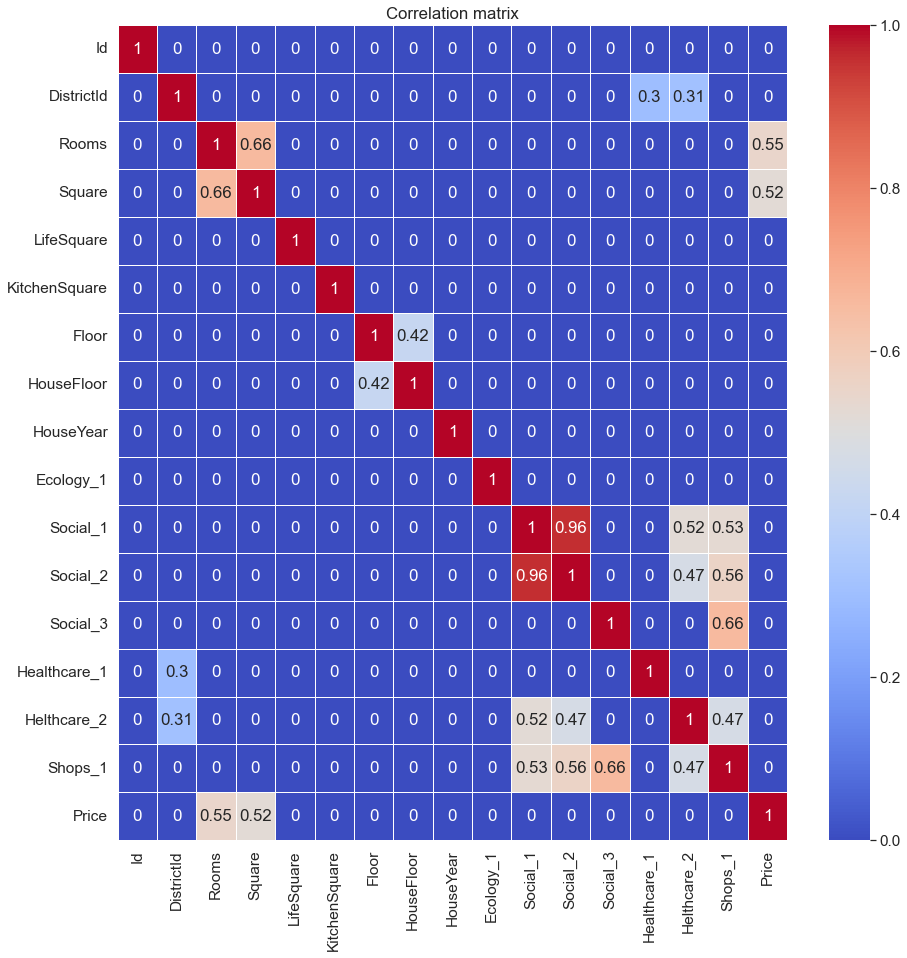

In [154]:
plt.figure(figsize=(15, 15))

sb.set(font_scale=1.4)

corr_matrix = train_df.corr()
corr_matrix = np.round(corr_matrix, 2)
corr_matrix[np.abs(corr_matrix) < .3] = 0

sb.heatmap(corr_matrix, annot=True, linewidths=.6, cmap='coolwarm')
plt.title('Correlation matrix')
plt.show()

Исходя из матрицы корреляций, такие признаки как "Social_1" и "Social_2" сильно коррелируют. Иключение как одного так и другого параметра не оказало значимого влияния на качество предсказания ни одной из моделей.

## 6. Обработка данных

In [163]:
corrected_dataframe = DataPipeLine()
corrected_dataframe.get_stat(train_df)

train_df = corrected_dataframe.correcting_data(train_df)
test_df = corrected_dataframe.correcting_data(test_df)

In [177]:
train_df.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price,Ecology_2_bin,Ecology_3_bin,Shops_2_bin,QuantityHousesInTheDistrics,MedianSquareMeterPriceByDistrict
0,11809,27,3.0,115.027311,32.781260,10.0,4,10.0,2014,0.075424,...,900.0,0,0,B,305018.871089,1,1,1,851,2707.753999
1,3013,22,1.0,39.832524,23.169223,8.0,7,8.0,1966,0.118537,...,1183.0,1,0,B,177734.553407,1,1,1,78,3728.145740
2,8215,1,3.0,78.342215,47.671972,10.0,2,17.0,1988,0.025609,...,240.0,3,1,B,282078.720850,1,1,1,652,3157.363817
3,2352,1,1.0,40.409907,32.781260,6.0,10,22.0,1977,0.007122,...,900.0,0,1,B,168106.007630,1,1,1,652,3157.363817
4,13866,94,2.0,64.285067,38.562517,9.0,16,16.0,1972,0.282798,...,900.0,0,6,B,343995.102962,1,1,1,89,4171.321353


In [400]:
test_df.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Ecology_2_bin,Ecology_3_bin,Shops_2_bin,QuantityHousesInTheDistrics,MedianSquareMeterPriceByDistrict
0,4567,44,1.0,36.847630,19.094182,6.0,5,9.0,1970,0.036122,...,0,1036.0,1,1,B,1,1,1,46,4537.312198
1,5925,62,1.0,52.568133,42.568133,10.0,7,17.0,2017,0.072158,...,1,900.0,0,0,A,1,1,0,122,2750.999956
2,960,27,2.0,59.463678,32.781260,9.0,19,19.0,1977,0.211401,...,0,900.0,0,1,B,1,1,1,391,2707.753999
3,3848,23,3.0,49.646030,33.893825,6.0,2,2.0,1965,0.014073,...,0,900.0,0,0,B,1,1,1,264,2214.388732
4,746,74,1.0,53.837056,32.781260,6.0,8,17.0,1977,0.309479,...,4,990.0,0,6,B,1,1,1,61,3284.037344


Обзор и анализ данных привел к корректировкам датасета, отраженным в методе "correcting_data" класса "DataPipeLine".

## 7. Отбор признаков

In [164]:
feature_names = [
     'Rooms',
     'Square',
     'LifeSquare',
     'KitchenSquare',
     'Floor',
     'HouseFloor',
     'HouseYear',
     'Ecology_1',
     'Social_1',
     'Social_2',
     'Social_3',
     'Healthcare_1',
     'Helthcare_2',
     'Shops_1',
     'Ecology_2_bin',
     'Ecology_3_bin',
     'Shops_2_bin',
     'QuantityHousesInTheDistrics',
     'MedianSquareMeterPriceByDistrict']

target_name = 'Price'

## 8. Разбиение датасета на тренировочный и валидационный

In [165]:
X = train_df[feature_names]
y = train_df[target_name]

In [166]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size = .33, random_state = 17)

## 9. Стандартизация данных

In [167]:
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_train_scaled = pd.DataFrame(X_train_scaled, columns=feature_names)

X_valid_scaled = scaler.transform(X_valid)
X_valid_scaled = pd.DataFrame(X_valid_scaled, columns=feature_names)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6700 entries, 0 to 6699
Data columns (total 19 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   Rooms                             6700 non-null   float64
 1   Square                            6700 non-null   float64
 2   LifeSquare                        6700 non-null   float64
 3   KitchenSquare                     6700 non-null   float64
 4   Floor                             6700 non-null   float64
 5   HouseFloor                        6700 non-null   float64
 6   HouseYear                         6700 non-null   float64
 7   Ecology_1                         6700 non-null   float64
 8   Social_1                          6700 non-null   float64
 9   Social_2                          6700 non-null   float64
 10  Social_3                          6700 non-null   float64
 11  Healthcare_1                      6700 non-null   float64
 12  Helthc

## 10. Построение и выбор модели

In [168]:
# создаем словарь, в котором ключи - это названия моделей, а значениями являются непосредственно сами модели
models = {
    'LinearRegression': LinearRegression(),
    'RandomForestRegressor': RandomForestRegressor(max_depth=15, min_samples_split=100, n_estimators=300, n_jobs=-1, random_state=17),
    'KNeighborsRegressor': KNeighborsRegressor(n_neighbors=6),
    'SVR': SVR(C=100, kernel='linear')    
    }

# словарь для записи имени модели, а также выбранной метрики качества, для последующего их включения в датафрейм
models_results = {}

# пустой датафрейм для записи результатов каждой модели
ModelsResults = pd.DataFrame()

# цикл, в котором для каждой модели, взятой из словаря "models"
for name in models:
    model = models[name]
    
    # выполняем обучние на тестовых данных
    model.fit(X_train_scaled, y_train)
    
    # записываем результат (R2_score) предсказания на тестовых и валидационных данных в подготовленный словарь
    models_results['ModelName'] = [name]
    models_results['R2 of Y_train'] = [r2(y_train, model.predict(X_train_scaled))]
    models_results['R2 of Y_valid'] = [r2(y_valid, model.predict(X_valid_scaled))]
    
    # добавляем полученный словарь в датасет
    ModelsResults = pd.concat([
        ModelsResults,
        pd.DataFrame(models_results)])

# меняем индекс датафрейма на имя моделей
ModelsResults.set_index('ModelName', inplace=True)

ModelsResults

,R2 of Y_train,R2 of Y_valid
ModelName,,
LinearRegression,0.638594,0.671526
RandomForestRegressor,0.784523,0.750779
KNeighborsRegressor,0.768879,0.683644
SVR,0.615884,0.673556


Как видно, лучший результат показывает "RandomForestRegressor", тем не менее как результаты этой модели, так и других.

### 10.1 Улучшение модели линейной регрессии

Попробуем оценить, какие веса каких признаков имеют самое наименьшее значение, а затем отбосить их и переобучить модель на новых данных

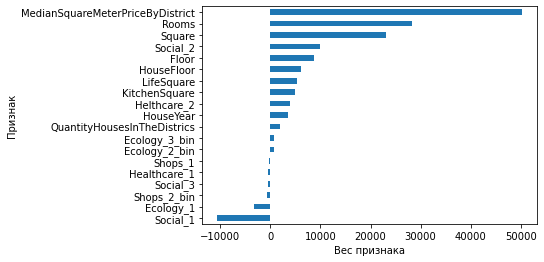

In [88]:
# coef = pd.Series(
#     models['LinearRegression'].coef_.flatten(),
#     index=X_train_scaled.columns)

# coef = coef.sort_values()
# coef.plot(kind='barh')

# plt.xlabel('Вес признака')
# plt.ylabel('Признак')

# plt.show()

Как видно, наименьшие веса имеют параметры "Shops_1", "Healthcare_1", "Social_3", "Shops_2_bin".
Попробуем отбросить их и переобучить модель заново.

In [94]:
# lr = LinearRegression()
# lr.fit(X_train_scaled.drop(columns=["Shops_1", "Healthcare_1", "Social_3", "Shops_2_bin"]), y_train)

# y_train_pred = lr.predict(X_train_scaled.drop(columns=["Shops_1", "Healthcare_1", "Social_3", "Shops_2_bin"]))
# y_valid_pred = lr.predict(X_valid_scaled.drop(columns=["Shops_1", "Healthcare_1", "Social_3", "Shops_2_bin"]))

In [97]:
# print(f'For train data {r2(y_train, y_train_pred)}')
# print(f'For valid data {r2(y_valid, y_valid_pred)}')


For train data 0.6384852652620816
For valid data 0.6718346951240662


Исключение малозначимых параметров какой-либо значимый эффект на качество предсказания линейной модели не оказало.

### 10.2 Подбор параметров для улучшения качества предсказания модели "случайный лес" 

Путем перебора во вложенных циклах параметров "n_estimators_list" и "max_depth_list" попробуем найти их сочетание, дающее качество выше полученного на шаге 10

In [118]:
# n_estimators_list = [i for i in range(100, 1050, 50)]
# max_depth_list = [i for i in range(3, 16)]

# r2_list_train = []
# r2_list_valid = []


# max_r2_train = 0
# max_r2_train_index = 0
# max_r2_valid = 0
# max_r2_valid_index = 0
# params_1 = []
# params_2 = []

# index = 0


In [119]:
# for n_estimators in n_estimators_list:
    
#     for max_depth in max_depth_list:
#         RFR = RandomForestRegressor(max_depth=max_depth, n_estimators=n_estimators, min_samples_split=100, n_jobs=-1, random_state=17)
#         RFR.fit(X_train_scaled, y_train)
        
#         y_train_pred = RFR.predict(X_train_scaled)
#         y_valid_pred = RFR.predict(X_valid_scaled)
        
#         r2_train = r2(y_train, y_train_pred)
#         r2_valid = r2(y_valid, y_valid_pred)
        
#         r2_list_train.append(r2_train)
#         r2_list_valid.append(r2_valid)
        
#         if r2_train > max_r2_train:
#             max_r2_train = r2_train 
#             max_r2_train_index = index
#             params_1 = [n_estimators, max_depth]
        
#         if r2_valid > max_r2_valid:
#             max_r2_valid = r2_valid 
#             max_r2_valid_index = index
#             params_2 = [n_estimators, max_depth]
        
#         index += 1
        

In [120]:
# print('max_r2_train ', max_r2_train)
# print('max_r2_train_index ', max_r2_train_index)
# print('max_r2_valid ', max_r2_valid)
# print('max_r2_valid_index ', max_r2_valid_index)

# print('params_1 ', params_1)
# print('params_2 ', params_2)

max_r2_train  0.7845819814527215
max_r2_train_index  25
max_r2_valid  0.7507788505653664
max_r2_valid_index  64
params_1  [150, 15]
params_2  [300, 15]


In [123]:
# print(r2_list_valid[25])
# print(r2_list_train[64])

0.7507141985841228
0.7845230966603722


При параметрах n_estimators=300, max_depth=15 удалось незначительно улучшить качество на валидационных данных.

### 10.3 Подбор параметров для улучшения качества предсказания модели "SVR"

In [135]:
# kernel_list = ['linear', 'rbf']
# C_list = np.logspace(-2, 3, 10)

# SVR_results = {}
# ResultsSVR = pd.DataFrame()

# for kernel in kernel_list:
    
#     for C in C_list: 

#         model_SVR = SVR(C=C, kernel=kernel)
#         model_SVR.fit(X_train_scaled, y_train)

#         y_train_pred = model_SVR.predict(X_train_scaled)
#         y_valid_pred = model_SVR.predict(X_valid_scaled)

#         SVR_results['kernel'] = [kernel]
#         SVR_results['r2_train'] = [r2(y_train, y_train_pred)]
#         SVR_results['r2_valid'] = [r2(y_valid, y_valid_pred)]
#         SVR_results['C'] = [C]

#         ResultsSVR = pd.concat([
#             ResultsSVR,
#             pd.DataFrame(SVR_results)])


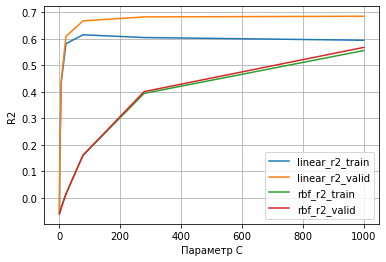

In [141]:
# plt.plot(
#     ResultsSVR.loc[ResultsSVR['kernel'] == 'linear', 'C'],
#     ResultsSVR.loc[ResultsSVR['kernel'] == 'linear', 'r2_train'],
#     label='linear_r2_train')

# plt.plot(
#     ResultsSVR.loc[ResultsSVR['kernel'] == 'linear', 'C'],
#     ResultsSVR.loc[ResultsSVR['kernel'] == 'linear', 'r2_valid'],
#     label='linear_r2_valid')

# plt.plot(
#     ResultsSVR.loc[ResultsSVR['kernel'] == 'rbf', 'C'],
#     ResultsSVR.loc[ResultsSVR['kernel'] == 'rbf', 'r2_train'],
#     label='rbf_r2_train')

# plt.plot(
#     ResultsSVR.loc[ResultsSVR['kernel'] == 'rbf', 'C'],
#     ResultsSVR.loc[ResultsSVR['kernel'] == 'rbf', 'r2_valid'],
#     label='rbf_r2_valid')

# plt.xlabel('Параметр С')
# plt.ylabel('R2')

# plt.legend()
# plt.grid()

# plt.show()

Согласно графика, лучший результат показывает линейный тип функции ядра при значении параметра наказания С=100

### 10.3 Подбор параметров для улучшения качества предсказания модели "KNN"

In [146]:
# n_neighbors_values = np.arange(2, 20)

# r2_train_list = []
# r2_valid_list = []

                        
# for i in n_neighbors_values:
#     KNR_model = KNeighborsRegressor(n_neighbors=i)
    
#     KNR_model.fit(X_train_scaled, y_train)

#     y_train_pred = KNR_model.predict(X_train_scaled)
#     y_valid_pred = KNR_model.predict(X_valid_scaled)

#     r2_train_list.append(r2(y_train, y_train_pred))
#     r2_valid_list.append(r2(y_valid, y_valid_pred))


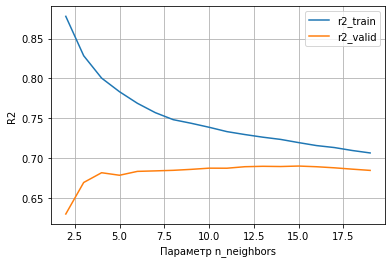

In [147]:
# plt.plot(n_neighbors_values, r2_train_list, label='r2_train')

# plt.plot(n_neighbors_values, r2_valid_list, label='r2_valid')


# plt.xlabel('Параметр n_neighbors')
# plt.ylabel('R2')

# plt.legend()
# plt.grid()

# plt.show()

График демонстрирует, что изначально выбранное значение n_neighbors=6 является оптимальным.

## 11 Формирование прогноза и файла с прогнозом

Лучший результат на этих данных дает модель "RandomForestRegressor", поэтому применим его для прогноза на тестовых данных.

In [257]:
test_df = pd.read_csv(TEST_DATASET_PATH)
predictions_df = pd.DataFrame()
predictions_df['Id'] = test_df['Id']

In [258]:
test_df = corrected_dataframe.correcting_data(test_df)

In [259]:
 test_df.loc[test_df['MedianSquareMeterPriceByDistrict'].isnull(), 'MedianSquareMeterPriceByDistrict'] = test_df['MedianSquareMeterPriceByDistrict'].mean()

In [260]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5000 entries, 0 to 4999
Data columns (total 24 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   Id                                5000 non-null   object 
 1   DistrictId                        5000 non-null   object 
 2   Rooms                             5000 non-null   float64
 3   Square                            5000 non-null   float64
 4   LifeSquare                        5000 non-null   float64
 5   KitchenSquare                     5000 non-null   float64
 6   Floor                             5000 non-null   int64  
 7   HouseFloor                        5000 non-null   float64
 8   HouseYear                         5000 non-null   int64  
 9   Ecology_1                         5000 non-null   float64
 10  Ecology_2                         5000 non-null   object 
 11  Ecology_3                         5000 non-null   object 
 12  Social

In [262]:
test_df = test_df[feature_names]

In [263]:
X_test_scaled = scaler.transform(test_df)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=feature_names)

In [264]:
predictions = models['RandomForestRegressor'].predict(X_test_scaled)

In [266]:
predictions_df['price'] = predictions
predictions_df.head()

,Id,price
0,4567,172901.254847
1,5925,131042.556348
2,960,153641.072765
3,3848,145314.734580
4,746,167271.352488


In [268]:
predictions_df.to_csv(PREDICTION_PATH, index=False)